### MSEplots functions --- adding ensembles of entrainment and detrainment, internal-gravity  waves
keyword arguments for the ensemble size, and h0 range <br>
fixed: "h4ent = mse" would replace mse as doing h4ent += h0offset, rewriting this part 

<br>
Date: 10/17

In [9]:
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime

import metpy.calc as mpcalc
from metpy.units import units
from metpy.constants import Cp_d,Lv,Rd,g 

In [10]:
def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin() # find minimum
    return (idx)

In [132]:
def thermo_plots(pressure,temperature,mixing_ratio):
    """"
    plots for vertical profiles of temperature, dewpoint, mixing ratio and relative humidity.
    
    Parameters
    ----------
    pressure : array-like
            Atmospheric pressure profile (surface to TOA)
    temperature: array-like
            Atmospheric temperature profile (surface to TOA)
    dewpoint: array-like
            Atmospheric dewpoint profile (surface to TOA)    
    Returns
    -------
    """
    p = pressure*units('mbar')
    q = mixing_ratio*units('kilogram/kilogram')
    T = temperature*units('degC')
    
    Td = mpcalc.dewpoint_from_specific_humidity(q,T,p) # dewpoint 
    Tp = mpcalc.parcel_profile(p,T[0],Td[0]) # parcel
    
    plt.figure(figsize = (12,5))
    
    lev = find_nearest(p.magnitude,100);
    plt.subplot(1,3,1)
    plt.plot(T[:lev],p[:lev],'-ob')
    plt.plot(Td[:lev],p[:lev],'-og')
    plt.plot(Tp[:lev],p[:lev],'-or')
    plt.xlabel('Temperature [C]',fontsize=12)
    plt.ylabel('Pressure [hpa]',fontsize=12)
    plt.gca().invert_yaxis()
    plt.legend(['Temp','Temp_Dew','Temp_Parcel'],loc=1)
    plt.grid()
    
    qs = mpcalc.mixing_ratio(mpcalc.saturation_vapor_pressure(T),p)
    # Relative humidity
    RH = q/qs*100 # Relative humidity

    plt.subplot(1,3,2)
    plt.plot(q[:lev],p[:lev],'-og')
    plt.xlabel('Mixing ratio [kg/kg]',fontsize=12)
    plt.gca().invert_yaxis()
    plt.grid()

    plt.subplot(1,3,3)
    plt.plot(RH[:lev],p[:lev],'-og')
    plt.xlabel('Relative humiduty [%]',fontsize=12)
    plt.gca().invert_yaxis()
    plt.grid()
    
    plt.tight_layout()
    return (plt)

def theta_plots(pressure,temperature,mixing_ratio):
    """
    plots for vertical profiles of potential temperature, equivalent potential temperature, 
    and saturated equivalent potential temperature
    """
    p = pressure*units('mbar')
    T = temperature*units('degC')
    q = mixing_ratio*units('kilogram/kilogram')
    
    lev = find_nearest(p.magnitude,100)
    Td = mpcalc.dewpoint(mpcalc.vapor_pressure(p,q)) # dewpoint 
    theta = mpcalc.potential_temperature(p,T)
    theta_e = mpcalc.equivalent_potential_temperature(p,T,Td)
    theta_es = mpcalc.equivalent_potential_temperature(p,T,T)
       
    plt.figure(figsize=(7,7))
    plt.plot(theta[:lev],p[:lev],'-ok')
    plt.plot(theta_e[:lev],p[:lev],'-ob')
    plt.plot(theta_es[:lev],p[:lev],'-or')
    plt.xlabel('Temperature [K]',fontsize=12)
    plt.ylabel('Pressure [hpa]',fontsize=12)
    plt.gca().invert_yaxis()
    plt.legend(['$\\theta$','$\\theta_e$','$\\theta_{es}$'],loc=1)
    plt.grid()
    return (plt)

def msed_plots(pressure,temperature,mixing_ratio,h0_std=2000,ensemble_size=20,entrain=True):
    """
    plotting the summarized static energy diagram with annotations and thermodynamic parameters
    """
    p  = pressure*units('mbar')
    T  = temperature*units('degC')
    q  = mixing_ratio*units('kilogram/kilogram')
    qs = mpcalc.mixing_ratio(mpcalc.saturation_vapor_pressure(T),p)
    Td = mpcalc.dewpoint_from_specific_humidity(q,T,p) # dewpoint 

    # Quality control, truncating data with missing values
    try:
        data_top=np.where(np.isnan(T)==1)[0][0]
    except:
        data_top=T.shape[0]
    
    data_top = find_nearest(p[:data_top],150)
    
    T=T[:data_top];p=p[:data_top];q=q[:data_top];
    qs=qs[:data_top];Td=Td[:data_top]
        
    # determine parcel_profile after QC
    Tp = mpcalc.parcel_profile(p,T[0],Td[0]) # parcel profile

    # Altitude based on the hydrostatic eq.
    altitude = np.zeros((np.size(T)))*units('meter') # surface is 0 meter
    for i in range(np.size(T)):
        altitude[i] = mpcalc.thickness_hydrostatic(p[:i+1],T[:i+1]) # Hypsometric Eq. for height
    altitude=altitude[:data_top]
    
    print(altitude[-1])
      
    # Static energy calculations   
    mse = mpcalc.moist_static_energy(altitude,T,q)
    mse_s = mpcalc.moist_static_energy(altitude,T,qs)
    dse = mpcalc.dry_static_energy(altitude,T)

    # Water vapor calculations
    p_PWtop = max(200*units.mbar, min(p) + 1*units.mbar) # integrating until 200mb 
    cwv = mpcalc.precipitable_water(Td,p,top=p_PWtop) # column water vapor [mm]
    cwvs = mpcalc.precipitable_water(T,p,top=p_PWtop) # saturated column water vapor [mm]
    crh = (cwv/cwvs)*100. # column relative humidity [%]

    #================================================
    # plotting MSE vertical profiles
    h = plt.figure(figsize=[10,8])
    plt.plot(dse,p,'-k',linewidth=2)
    plt.plot(mse,p,'-b',linewidth=2)
    plt.plot(mse_s,p,'-r',linewidth=2)
    
    # mse based on different percentages of relative humidity
    qr = np.zeros((9,np.size(qs)))*units('kilogram/kilogram'); mse_r = qr*units('joule/kilogram')# container
    for i in range(9):
        qr[i,:] = qs*0.1*(i+1)
        mse_r[i,:] = mpcalc.moist_static_energy(altitude,T,qr[i,:])

    for i in range(9):
        plt.plot(mse_r[i,:],p[:],'-',color='grey',linewidth=0.7)
        plt.text(mse_r[i,3].magnitude/1000-1,p[3].magnitude,str((i+1)*10))
                
    # drawing LCL and LFC levels
    [lcl_pressure, lcl_temperature] = mpcalc.lcl(p[0], T[0], Td[0])
    lcl_idx = np.argmin(np.abs(p.magnitude - lcl_pressure.magnitude))
    
    [lfc_pressure, lfc_temperature] = mpcalc.lfc(p,T,Td,parcel_temperature_profile=Tp)
    lfc_idx = np.argmin(np.abs(p.magnitude - lfc_pressure.magnitude))
    
    # conserved mse of air parcel arising from 1000 hpa    
    mse_p = np.squeeze(np.ones((1,np.size(T)))*mse[0].magnitude)
    
    # illustration of CAPE
    el_pressure,el_temperature = mpcalc.el(p,T,Td) # equilibrium level
    el_idx = np.argmin(np.abs(p.magnitude - el_pressure.magnitude))
    ELps = [el_pressure.magnitude] # Initialize an array of EL pressures for detrainment profile
    
    [CAPE,CIN] = mpcalc.cape_cin(p[:el_idx],T[:el_idx],Td[:el_idx],Tp[:el_idx])
    
    plt.plot(mse_p,p,color='green',linewidth=2)
    plt.fill_betweenx(p[lcl_idx:el_idx+1],mse_p[lcl_idx:el_idx+1],mse_s[lcl_idx:el_idx+1],interpolate=True
                    ,color='green',alpha='0.3')

    plt.fill_betweenx(p,dse,mse,color='deepskyblue',alpha='0.5')
    plt.xlim([280,380])
    plt.xlabel('Specific static energies: s, h, hs [kJ kg$^{-1}$]',fontsize=14)
    plt.ylabel('Pressure [hpa]',fontsize=14)
    plt.xticks(fontsize=12);plt.yticks(fontsize=12)
    plt.ylim(1030,150)
    
    if entrain is True:
    # Depict Entraining parcels
    # Parcel mass solves dM/dz = eps*M, solution is M = exp(eps*Z)
    # M=1 at ground without loss of generality
            
    # Distribution of surface parcel h offsets
        H0STDEV = h0_std # J/kg
        h0offsets = np.sort(np.random.normal(0, H0STDEV, ensemble_size))*units('joule/kilogram')
        # Distribution of entrainment rates 
        entrainment_rates = np.arange(0,2,0.05) /(units('km'))
        
        for h0offset in h0offsets:
            
            h4ent = mse.copy(); h4ent[0] += h0offset;
                
            for eps in entrainment_rates: 

                M = np.exp(eps * (altitude-altitude[0])).to('dimensionless')
                # dM is the mass contribution at each level, with 1 at the origin level. 
                M[0] = 0
                dM = np.gradient(M)

                # parcel mass is a  sum of all the dM's at each level
                # conserved linearly-mixed variables like h are weighted averages 
                hent = np.cumsum(dM*h4ent) / np.cumsum(dM)
    
                # Boolean for positive buoyancy, and its topmost altitude (index) where curve is clippes
                posboy  = (hent > mse_s); posboy[0] = True  # so there is always a detrainment level
        
                ELindex_ent = np.max(np.where(posboy))
                # Plot the curve        
                plt.plot( hent[0:ELindex_ent+2], p[0:ELindex_ent+2], linewidth=0.25, color='g')
                # Keep a list for a histogram plot (detrainment profile)
                if np.isnan(p[ELindex_ent])==0:
                    ELps.append( p[ELindex_ent].magnitude )
        
        print(ELps[:50])
        
        # Plot a crude histogram of parcel detrainment levels
        NBINS = 50
        hist, pbins = np.histogram(ELps[:], bins=NBINS)
        norm = 20/max(hist[0:NBINS-2]) # scale the plot to 20 kJ/kg for the eye 
            
        plt.plot( 360+hist[:]*norm, pbins[1:], color='purple')
        plt.plot( [360,360], [1100,0])
        plt.annotate('Detrainment', xy=(362, 400), color='purple')
           
        # Overplots on the mess: undilute parcel and CAPE, etc. 
        plt.plot( (1,1)*mse[0], (1,0)*(p[0]), color='g',linewidth=2)
        #maxbindex = np.argmax(Tp - temperature)
        #ax.annotate('CAPE='+str(int(CAPE.magnitude)), 
        #              xy=(parcelh/1000., p[maxbindex]), color='g')

        # Replot the sounding on top of all that mess
        plt.plot(mse_s , p, color='r', linewidth=1.5) 
        plt.plot(mse , p, color='b', linewidth=1.5) 

        # label LCL and LCF
        plt.plot((mse_s[lcl_idx]+(-2000,2000)*units('joule/kilogram')), lcl_pressure+(0,0)*units('mbar') ,color='orange',linewidth=3)
        plt.plot((mse_s[lfc_idx]+(-2000,2000)*units('joule/kilogram')), lfc_pressure+(0,0)*units('mbar') , color='magenta',linewidth=3)
  
    
    ### Internal waves (100m adiabatic displacements, assumed adiabatic: conserves s, sv, h). 
    #dZ = 100 *mpunits.units.meter
    dp = 1000*units.pascal
    
    # depict displacements at sounding levels nearest these target levels
    targetlevels = [900,800,700,600,500,400,300,200]*units.hPa
    for ilev in targetlevels:
        idx = np.argmin(np.abs(p - ilev))

        # dp: hydrostatic
        rho = (p[idx])/Rd/(T[idx])
        dZ = -dp/rho/g

        # dT: Dry lapse rate dT/dz_dry is -g/Cp
        dT = (-g/Cp_d *dZ).to('kelvin')    
        Tdisp = T[idx].to('kelvin') + dT

        # dhsat
        dqs = mpcalc.mixing_ratio(mpcalc.saturation_vapor_pressure(Tdisp) ,p[idx]+dp) - qs[idx]
        dhs = g*dZ + Cp_d*dT + Lv*dqs

        # Whiskers on the data plots
        plt.plot( (mse_s[idx]+dhs*(-1,1)), p[idx]+dp*(-1,1), linewidth=3, color='r')  
        plt.plot( (dse[idx]    *( 1,1)), p[idx]+dp*(-1,1), linewidth=3, color='r')  
        plt.plot( (mse[idx]    *( 1,1)), p[idx]+dp*(-1,1), linewidth=3, color='b')  

        # annotation to explain it 
        if ilev == 600*ilev.units:
            plt.plot(370*mse_s.units +dhs*(-1,1)/1000, p[idx]
                     +dp*(-1,1), linewidth=3, color='r')  
            plt.annotate('+/- 10mb', xy=(370,600), fontsize=8)
            plt.annotate('   adiabatic', xy=(370,630), fontsize=8)
            plt.annotate(' displacement', xy=(370,660), fontsize=8)
    
# Plot a crude histogram of parcel detrainment levels
    # Text parts
    plt.text(290,pressure[3],'RH (%)',fontsize=11,color='k')
    plt.text(285,250,'CAPE = '+str(np.around(CAPE.magnitude,decimals=2))+' [J/kg]',fontsize=12,color='green')
    plt.text(285,300,'CIN = '+str(np.around(CIN.magnitude,decimals=2))+' [J/kg]',fontsize=12,color='green')
    plt.text(285,350,'LCL = '+str(np.around(lcl_pressure.magnitude,decimals=2))+' [hpa]',fontsize=12,color='orange')
    plt.text(285,400,'LFC = '+str(np.around(lfc_pressure.magnitude,decimals=2))+' [hpa]',fontsize=12,color='magenta')
    plt.text(285,450,'CWV = '+str(np.around(cwv.magnitude,decimals=2))+' [mm]',fontsize=12,color='deepskyblue')
    plt.text(285,500,'CRH = '+str(np.around(crh.magnitude,decimals=2))+' [%]',fontsize=12,color='blue')
    plt.legend(['DSE','MSE','SMSE'],fontsize=12,loc=1)
    plt.xlim([280,400]);
    
    return (plt)

In [24]:
import os
import scipy.io
from metpy.calc import find_intersections
os.chdir('/Users/willy/Desktop/IOP4/')

In [130]:
qcd = scipy.io.loadmat('qall.mat')
qcd1=qcd['qall'][:,3]
q=qcd1/1000 #*units('kilogram/kilogram')

pcd = scipy.io.loadmat('pall.mat')
p = pcd['pall'][:,3] #*units('mbar')

tcd = scipy.io.loadmat('Tall.mat')
t=tcd['tall'][:,3] #*units('degC')

zcd = scipy.io.loadmat('Zall.mat')
z=zcd['zall'][:,3] #*units('meter')

3449


<Quantity([851.85369944 660.97645718 646.30509434 640.9981083  187.3799669 ], 'dimensionless')>

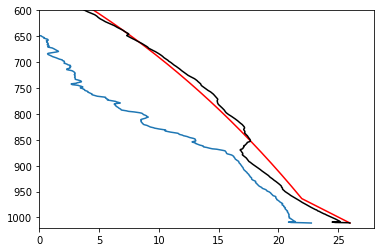

In [162]:
try:
    data_top=np.where(np.isnan(t)==1)[0][0]
except:
    data_top=t.shape[0]
    
data_top = find_nearest(p[:data_top],150); print(data_top)

td = mpcalc.dewpoint_from_specific_humidity(q[:data_top],t[:data_top]*units('degC'),p[:data_top]*units('mbar'))
tp = mpcalc.parcel_profile(p[:data_top]*units('mbar'),t[0]*units('degC'),td[0]).to('degC')
plt.plot(tp.magnitude[:data_top],p[:data_top],'r',t[:data_top],p[:data_top],'k',td[:data_top].magnitude,p[:data_top])
plt.gca().invert_yaxis();plt.ylim(1020,600);plt.xlim([0,28])

x, y = find_intersections(p[1:data_top], tp[1:data_top].magnitude,
                              t[1:data_top], direction='all')
x

/Users/willy/anaconda3/lib/python3.6/site-packages/pint/quantity.py:1065: RuntimeWarning: invalid value encountered in greater
  return op(self._convert_magnitude_not_inplace(UnitsContainer()), other)


14196.846293473576 meter
[187.37996690198247, 868.2265792500001, 868.6549265, 868.6549265, 869.080025, 869.080025, 869.500987, 872.659995625, 874.0382994999999, 876.26559425, 877.194948125, 877.690840375, 878.1970638749999, 878.1970638749999, 878.680446875, 879.171102375, 891.3390234999999, 1010.7674999999999, 1010.7674999999999, 1010.7674999999999, 1010.7674999999999, 1010.7674999999999, 1010.7674999999999, 1010.7674999999999, 1010.7674999999999, 1010.7674999999999, 1010.7674999999999, 1010.7674999999999, 1010.7674999999999, 1010.7674999999999, 1010.7674999999999, 1010.7674999999999, 1010.7674999999999, 1010.7674999999999, 1010.7674999999999, 1010.7674999999999, 1010.7674999999999, 1010.7674999999999, 1010.7674999999999, 1010.7674999999999, 1010.7674999999999, 261.3699105, 864.799112, 865.26145425, 866.1639122500001, 867.000904625, 867.41919925, 867.81872525, 867.81872525, 868.2265792500001]


<module 'matplotlib.pyplot' from '/Users/willy/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py'>

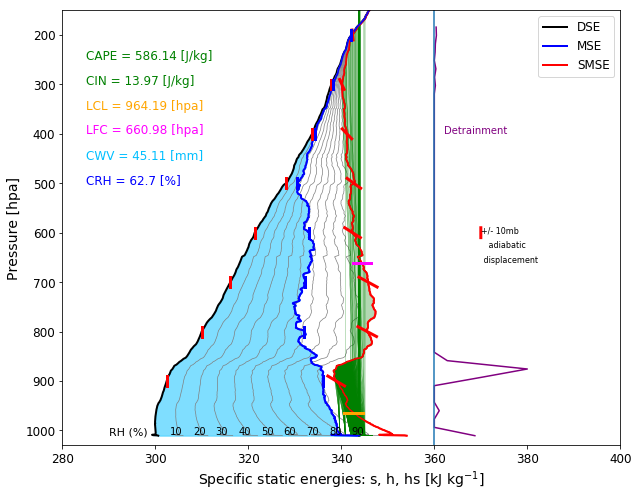

In [133]:
msed_plots(p,t,q,entrain=True)

In [ ]:
plt.plot(np.isnan(q)==1)